In [418]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler


In [419]:
# load 6 modalites data 
from sklearn.utils import resample
import numpy as np
import pandas as pd

def load_data():
    cln_data = pd.read_csv('data/raw_features_cln.csv')
    cnv_data = pd.read_csv('data/raw_features_cnv.csv')
    dna_data = pd.read_csv('data/raw_features_dna.csv')
    mir_data = pd.read_csv('data/raw_features_mir.csv')
    mrna_data = pd.read_csv('data/raw_features_mrna.csv')
    wsi_data = pd.read_csv('data/raw_features_wsi.csv')

    # keep data where all modalities are present based on patient id
    patient_ids = set(cln_data['submitter_id.samples'])
    patient_ids = patient_ids.intersection(set(cnv_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(dna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mir_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(mrna_data['submitter_id.samples']))
    patient_ids = patient_ids.intersection(set(wsi_data['submitter_id.samples']))

    cln_data = cln_data[cln_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    cnv_data = cnv_data[cnv_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    dna_data = dna_data[dna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mir_data = mir_data[mir_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    mrna_data = mrna_data[mrna_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)
    wsi_data = wsi_data[wsi_data['submitter_id.samples'].isin(patient_ids)].reset_index(drop=True)

    # sort data by patient id
    cln_data = cln_data.sort_values('submitter_id.samples').reset_index(drop=True)
    cnv_data = cnv_data.sort_values('submitter_id.samples').reset_index(drop=True)
    dna_data = dna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mir_data = mir_data.sort_values('submitter_id.samples').reset_index(drop=True)
    mrna_data = mrna_data.sort_values('submitter_id.samples').reset_index(drop=True)
    wsi_data = wsi_data.sort_values('submitter_id.samples').reset_index(drop=True)

    # make sure the labels column match for all modalities
    cln_labels = cln_data['label_cln']
    cnv_labels = cnv_data['label_cnv']
    dna_labels = dna_data['label_dna']
    mir_labels = mir_data['label_mir']
    mrna_labels = mrna_data['label_mrna']
    wsi_labels = wsi_data['label_wsi']

    assert np.all(cln_labels == cnv_labels), "Labels mismatch between clinical and CNV data"
    assert np.all(cln_labels == dna_labels), "Labels mismatch between clinical and DNA data"
    assert np.all(cln_labels == mir_labels), "Labels mismatch between clinical and miRNA data"
    assert np.all(cln_labels == mrna_labels), "Labels mismatch between clinical and mRNA data"
    # assert np.all(cln_labels == wsi_labels), "Labels mismatch between clinical and WSI data"

    # drop labels column and patient id column
    cln_data = cln_data.drop(columns=['label_cln', 'submitter_id.samples'])
    cnv_data = cnv_data.drop(columns=['label_cnv', 'submitter_id.samples'])
    dna_data = dna_data.drop(columns=['label_dna', 'submitter_id.samples'])
    mir_data = mir_data.drop(columns=['label_mir', 'submitter_id.samples'])
    mrna_data = mrna_data.drop(columns=['label_mrna', 'submitter_id.samples'])
    wsi_data = wsi_data.drop(columns=['label_wsi', 'submitter_id.samples'])

    # normalize data
    stdscalar = StandardScaler()
    cln_data = stdscalar.fit_transform(cln_data)
    cnv_data = stdscalar.fit_transform(cnv_data)
    dna_data = stdscalar.fit_transform(dna_data)
    mir_data = stdscalar.fit_transform(mir_data)
    mrna_data = stdscalar.fit_transform(mrna_data)
    wsi_data = stdscalar.fit_transform(wsi_data)

    return cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, cln_labels


from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler

def balance_modality_data(features_list, labels, method='SMOTE'):
    """
    Balances the dataset for each modality separately.
    
    Parameters:
    - features_list: List of feature matrices, one for each modality.
    - labels: Binary labels (numpy array or Series).
    - method: Balancing method ('SMOTE' supported here).
    
    Returns:
    - Separate balanced feature matrices for each modality.
    - Balanced labels (same across all modalities).
    """
    smote = SMOTE(random_state=42)
    balanced_features_list = []
    
    for modality_features in features_list:
        # Balance the current modality's features and labels
        balanced_modality_features, balanced_labels = smote.fit_resample(modality_features, labels)
        balanced_features_list.append(balanced_modality_features)
    
    # Unpack balanced features into separate variables and return them
    return balanced_features_list, balanced_labels

if __name__ == '__main__':
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    
    # List of modalities
    features_list = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    
    # Balance the modalities and unpack them
    balanced_data, balanced_labels = balance_modality_data(features_list, labels, method='SMOTE')
    
    # Print shapes
    print("\nBalanced shapes of modalities:")
    for i, modality_data in enumerate(balanced_data):
        print(f"Modality {i+1}: {modality_data.shape}")

    # Class distribution
    print("\nClass distribution after balancing:")
    print(f"Positive samples: {np.sum(balanced_labels == 1)}")
    print(f"Negative samples: {np.sum(balanced_labels == 0)}")




Balanced shapes of modalities:
Modality 1: (1592, 19)
Modality 2: (1592, 500)
Modality 3: (1592, 500)
Modality 4: (1592, 500)
Modality 5: (1592, 500)
Modality 6: (1592, 800)

Class distribution after balancing:
Positive samples: 796
Negative samples: 796


In [420]:
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split

# Define a MultimodalDataset class if not already defined
class MultimodalDataset(Dataset):
    def __init__(self, *modalities, labels):
        self.modalities = modalities
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return tuple(modality[idx] for modality in self.modalities) + (self.labels[idx],)


def load_and_split_data(modalities, labels, test_size=0.2, random_state=73):
    """
    Splits the data into train and test sets, and balances the test set.
    """
    # Split the data into train and test sets
    train_modalities, test_modalities = [], []
    for modality in modalities:
        train, test = train_test_split(modality, test_size=test_size, random_state=random_state)
        train_modalities.append(train)
        test_modalities.append(test)

    labels_train, labels_test = train_test_split(labels, test_size=test_size, random_state=random_state)

    return train_modalities, test_modalities, labels_train, labels_test

# Function to convert data to tensors
def convert_to_tensors(data):
    return [torch.tensor(modality, dtype=torch.float32) for modality in data]

# Main code
def get_train_test_loader(balane=True):
    # Load the data
    cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data, labels = load_data()
    modalities = [cln_data, cnv_data, dna_data, mir_data, mrna_data, wsi_data]
    # Split data
    train_modalities, test_modalities, labels_train, labels_test = load_and_split_data(modalities, labels)

    train_modalities, labels_train = balance_modality_data(train_modalities, labels_train)

    # Convert data to tensors
    train_tensors = convert_to_tensors(train_modalities)
    test_tensors = convert_to_tensors(test_modalities)
    labels_train = torch.tensor(labels_train, dtype=torch.long)
    labels_test = torch.tensor(labels_test.to_numpy(), dtype=torch.long)

    # Create datasets and dataloaders
    train_dataset = MultimodalDataset(*train_tensors, labels=labels_train)
    test_dataset = MultimodalDataset(*test_tensors, labels=labels_test)

    batch_size = 32
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

# Run the main function
train_loader, test_loader = get_train_test_loader()


In [421]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Define SupConLoss (unchanged)
class SupConLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels=None):
        device = features.device
        batch_size = features.shape[0]
        mask = torch.eye(batch_size, dtype=torch.bool).to(device)

        if labels is not None:
            labels = labels.contiguous().view(-1, 1)
            mask = torch.eq(labels, labels.T).to(device)

        # Normalize features
        features = nn.functional.normalize(features, dim=1)

        # Similarity matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        # Exclude self-similarity
        logits_mask = torch.ones_like(mask).fill_diagonal_(0)
        masked_sim = similarity_matrix * logits_mask

        # Compute loss
        logits = torch.exp(masked_sim)
        logits_sum = logits.sum(dim=1, keepdim=True)
        loss = -torch.log(logits / logits_sum)
        loss = (loss * mask).sum() / mask.sum()
        return loss

# Define the MultimodalEncoder with a classification head
class MultimodalEncoderWithClassifier(nn.Module):
    def __init__(self, input_dims, hidden_dims, output_dim, num_classes=2):
        super(MultimodalEncoderWithClassifier, self).__init__()
        self.encoders = nn.ModuleList([
            nn.Sequential(
                nn.Linear(input_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, output_dim)
            ) for input_dim, hidden_dim in zip(input_dims, hidden_dims)
        ])
        self.classifier = nn.Linear(output_dim * len(input_dims), num_classes)  # Binary classification head

    def forward(self, modalities):
        embeddings = [encoder(modality) for encoder, modality in zip(self.encoders, modalities)]
        combined_embeddings = torch.cat(embeddings, dim=1)  # Concatenate embeddings from all modalities
        class_logits = self.classifier(combined_embeddings)
        return embeddings, class_logits

# Simulated Data (replace with real data and loaders)
input_dims = [19, 500, 500, 500, 500, 800]
hidden_dims = [128, 128, 128, 128, 128, 128]  # Adjust as needed
output_dim = 64
num_classes = 2  # Binary classification

# Initialize model
model = MultimodalEncoderWithClassifier(input_dims, hidden_dims, output_dim, num_classes)
criterion_supcon = SupConLoss()
criterion_classification = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 1.0]))  # Adjust weights as needed
optimizer = optim.Adam(model.parameters(), lr=1e-4)
epochs = 10

# Training loop
for epoch in range(epochs):
    model.train()
    total_loss = 0
    total_class_loss = 0
    for batch in train_loader:
        modalities, labels = batch[:-1], batch[-1]
        modalities = [modality for modality in modalities]

        # Forward pass
        embeddings, class_logits = model(modalities)  # List of embeddings and classification logits

        # Combine embeddings for SupConLoss
        features = torch.cat(embeddings, dim=1)  # Combine all modality embeddings
        batch_size = features.shape[0]
        labels_expanded = labels.repeat_interleave(len(input_dims))  # Adjust labels for SupConLoss

        # Reshape features for SupConLoss (batch_size * num_modalities, output_dim)
        features = features.view(batch_size, len(input_dims), output_dim)  # Shape: (batch_size, num_modalities, output_dim)
        features = features.view(batch_size * len(input_dims), output_dim)  # Shape: (batch_size * num_modalities, output_dim)

        # Compute SupConLoss
        loss_supcon = criterion_supcon(features, labels_expanded)

        # Compute classification loss
        loss_class = criterion_classification(class_logits, labels)

        # Total loss is a combination of SupConLoss and classification loss
        total_loss_combined = loss_supcon + loss_class

        # Backprop and optimize
        optimizer.zero_grad()
        total_loss_combined.backward()
        optimizer.step()

        # Track losses
        total_loss += loss_supcon.item()
        total_class_loss += loss_class.item()

    print(f"Epoch {epoch + 1}/{epochs}, SupConLoss: {total_loss / len(train_loader):.4f}, Class Loss: {total_class_loss / len(train_loader):.4f}")


Epoch 1/10, SupConLoss: 8.1403, Class Loss: 0.6894
Epoch 2/10, SupConLoss: 6.2974, Class Loss: 0.6588
Epoch 3/10, SupConLoss: 5.7864, Class Loss: 0.6241
Epoch 4/10, SupConLoss: 5.6122, Class Loss: 0.5886
Epoch 5/10, SupConLoss: 5.5260, Class Loss: 0.5482
Epoch 6/10, SupConLoss: 5.4764, Class Loss: 0.5053
Epoch 7/10, SupConLoss: 5.4413, Class Loss: 0.4571
Epoch 8/10, SupConLoss: 5.4125, Class Loss: 0.4064
Epoch 9/10, SupConLoss: 5.3862, Class Loss: 0.3529
Epoch 10/10, SupConLoss: 5.3647, Class Loss: 0.2999


Accuracy: 0.6940
AUC: 0.5174
F1 Score: 0.8066
Precision: 0.7822
Recall: 0.8403
Specificity: 0.2186
MCC: 0.0764
AUPRC: 0.7946


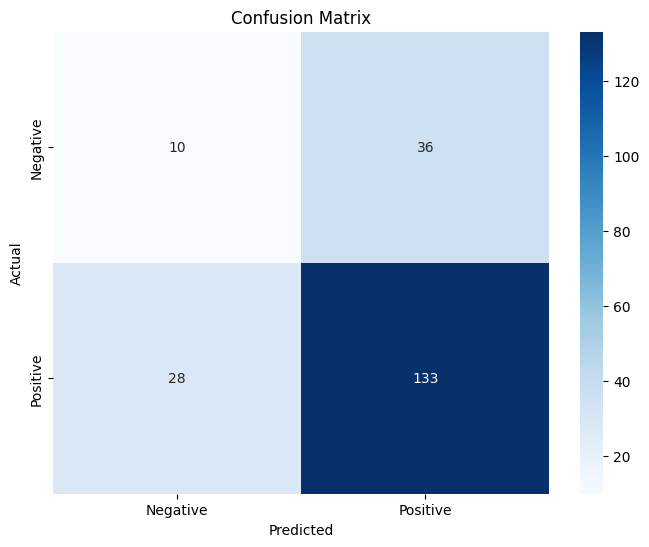

In [422]:
import torch
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef, average_precision_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def evaluate_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    # Initialize the metrics
    total_accuracy = 0
    total_auc = 0
    total_f1 = 0
    total_precision = 0
    total_recall = 0
    total_specificity = 0
    total_mcc = 0
    total_auprc = 0
    total_samples = 0

    with torch.no_grad():  # No need to compute gradients during evaluation
        for batch in test_loader:
            modalities, labels = batch[:-1], batch[-1]
            modalities = [modality for modality in modalities]

            # Forward pass
            _, class_logits = model(modalities)
            probs = torch.softmax(class_logits, dim=1)[:, 1]  # Get probabilities for class 1 (positive class)
            preds = (probs > 0.5).long()  # Convert probabilities to binary predictions

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Calculate metrics for each batch
            accuracy = accuracy_score(labels.cpu(), preds.cpu())
            auc = roc_auc_score(labels.cpu(), probs.cpu())
            f1 = f1_score(labels.cpu(), preds.cpu())
            precision = precision_score(labels.cpu(), preds.cpu())
            recall = recall_score(labels.cpu(), preds.cpu())

            # Specificity = TN / (TN + FP)
            tn, fp, fn, tp = confusion_matrix(labels.cpu(), preds.cpu()).ravel()
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

            mcc = matthews_corrcoef(labels.cpu(), preds.cpu())
            auprc = average_precision_score(labels.cpu(), probs.cpu())

            total_accuracy += accuracy
            total_auc += auc
            total_f1 += f1
            total_precision += precision
            total_recall += recall
            total_specificity += specificity
            total_mcc += mcc
            total_auprc += auprc
            total_samples += 1

    # Calculate averages
    metrics = {
        "accuracy": total_accuracy / total_samples,
        "auc": total_auc / total_samples,
        "f1": total_f1 / total_samples,
        "precision": total_precision / total_samples,
        "recall": total_recall / total_samples,
        "specificity": total_specificity / total_samples,
        "mcc": total_mcc / total_samples,
        "auprc": total_auprc / total_samples
    }

    # Print the metrics
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"AUC: {metrics['auc']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print(f"MCC: {metrics['mcc']:.4f}")
    print(f"AUPRC: {metrics['auprc']:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)
    plot_confusion_matrix(cm)

    return metrics


def plot_confusion_matrix(cm):
    # Plot confusion matrix using seaborn heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

# Example Usage:
# Assuming you have a trained model and a test loader `test_loader`
metrics = evaluate_model(model, test_loader)


In [423]:
# # save the model
# torch.save(model.state_dict(), 'model.pth')

# # load the model
# model = MultimodalEncoderWithClassifier(input_dims, hidden_dims, output_dim, num_classes)
# model.load_state_dict(torch.load('model.pth'))

# # Evaluate the loaded model
# metrics = evaluate_model(model, test_loader)